# maxvogt-analysis: Uetikon

The code in this notebook is based on [Martin Fleischmann's](https://martinfleischmann.net/) 2021 workshop [*Capturing the Structure of Cities with Data Science (SDSC)*](https://github.com/martinfleis/sdsc21-workshop), licensed under the [CC BY-SA 4.0 license](https://creativecommons.org/licenses/by-sa/4.0/). © 2021 Martin Fleischmann.

The geodata in this notebook is retrieved from OpenStreetMap. © OpenStreetMap Contributors.

<hr>

This notebook contains geodata and analyses for the following items of the [Max Vogt collection](https://mtwente.github.io/maxvogt/) by Moritz Twente and Luisa Omonsky:
- [UET030](https://mtwente.github.io/maxvogt/items/uet030.html)
- [UET130](https://mtwente.github.io/maxvogt/items/uet130.html)

<hr>

Open in an interactive in-browser environment: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/mtwente/maxvogt-analysis/main?labpath=analysis%2Fuetikon.ipynb)

In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Uetikon'
point = 47.25902, 8.67916
address = 'Alte Landstrasse 144, 8707 Uetikon am See'
dist = 2000
local_crs = 'EPSG:2056'

In [3]:
geopandas.tools.geocode(address).explore()

## Input data

Download data from OpenStreetMap.

### Buildings

In [4]:
#buildings = osmnx.features.features_from_place(place, tags={'building':True})
#buildings = osmnx.features.features_from_address(address, tags={'building':True}, dist=dist)
buildings = osmnx.features.features_from_point(point, tags={'building':True}, dist=dist)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [5]:
buildings

geometry  \
element_type osmid                                                           
node         444628323                            POINT (8.69036 47.25319)   
             5630876041                           POINT (8.69762 47.25597)   
way          21642426    POLYGON ((8.67801 47.26433, 8.67796 47.26394, ...   
             23793021    POLYGON ((8.70555 47.25559, 8.70582 47.25548, ...   
             23793023    POLYGON ((8.70581 47.25580, 8.70554 47.25591, ...   
...                                                                    ...   
relation     1122229     POLYGON ((8.67891 47.26474, 8.67883 47.26456, ...   
             3687978     POLYGON ((8.69444 47.25146, 8.69413 47.25159, ...   
             3688008     POLYGON ((8.69676 47.25073, 8.69666 47.25063, ...   
             4458805     MULTIPOLYGON (((8.69064 47.25284, 8.69082 47.2...   
             8350122     POLYGON ((8.70188 47.25408, 8.70187 47.25414, ...   

                            access       addr:city addr:housenumber  \
element_type osmid                                                    
node         444628323         NaN             NaN              NaN   
             5630876041        NaN             NaN              NaN   
way          21642426          NaN  Uetikon am See              122   
             23793021          NaN       Männedorf               17   
             23793023          NaN       Männedorf                5   
...                            ...             ...              ...   
relation     1122229           NaN             NaN              NaN   
             3687978     customers       Männedorf              NaN   
             3688008           NaN             NaN              NaN   
             4458805           NaN             NaN              NaN   
             8350122           NaN             NaN              NaN   

                        addr:postcode    addr:street shop    building  \
element_type osmid                                                      
node         444628323            NaN            NaN  NaN      public   
             5630876041           NaN            NaN  NaN         yes   
way          21642426            8707    Bergstrasse  NaN      school   
             23793021            8708  Birkenstrasse  NaN  apartments   
             23793023            8708  Birkenstrasse  NaN  apartments   
...                               ...            ...  ...         ...   
relation     1122229              NaN            NaN  NaN         yes   
             3687978             8708    Bergstrasse  NaN     parking   
             3688008              NaN            NaN  NaN    hospital   
             4458805              NaN            NaN  NaN         yes   
             8350122              NaN            NaN  NaN  apartments   

                                        name opening_hours  ...  \
element_type osmid                                          ...   
node         444628323        Betreibungsamt           NaN  ...   
             5630876041                  NaN           NaN  ...   
way          21642426    Sporthalle Riedwies           NaN  ...   
             23793021                    NaN           NaN  ...   
             23793023                    NaN           NaN  ...   
...                                      ...           ...  ...   
relation     1122229          St. Franziskus           NaN  ...   
             3687978                     NaN           NaN  ...   
             3688008                Südtrakt           NaN  ...   
             4458805         zum Wilden Mann           NaN  ...   
             8350122                     NaN           NaN  ...   

                        payment:lightning_contactless payment:onchain  \
element_type osmid                                                      
node         444628323                            NaN             NaN   
             5630876041                           NaN             NaN   
way          

In [6]:
buildings.geom_type.value_counts()

Polygon         4208
Point              2
MultiPolygon       1
Name: count, dtype: int64

In [7]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

In [8]:
buildings = buildings[["geometry"]].to_crs(local_crs)

In [9]:
buildings["uID"] = range(len(buildings))

In [10]:
buildings

geometry   uID
0     POLYGON ((2693795.210 1235565.465, 2693791.889...     0
1     POLYGON ((2695894.546 1234627.262, 2695915.207...     1
2     POLYGON ((2695913.787 1234650.423, 2695893.055...     2
3     POLYGON ((2695853.464 1234658.044, 2695874.455...     3
4     POLYGON ((2695859.031 1234690.258, 2695880.444...     4
...                                                 ...   ...
4203  POLYGON ((2693938.889 1235235.205, 2693936.201...  4203
4204  POLYGON ((2693862.140 1235612.145, 2693856.724...  4204
4205  POLYGON ((2695061.258 1234154.718, 2695037.705...  4205
4206  POLYGON ((2695237.645 1234075.984, 2695230.440...  4206
4207  POLYGON ((2695619.791 1234454.842, 2695618.918...  4207

[4208 rows x 2 columns]

### Streets

In comparison to Martin Fleischmann's workshop, I here set `truncate_by_edge` to be `True`.
Depending on the OSM mapping quality of the place at hand, it might also be necessary to change the value of `network_type`. See [geopandas documentation](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.graph.graph_from_place) for options.

In [11]:
#osm_graph = osmnx.graph_from_place(place, network_type='drive', truncate_by_edge=True)
#osm_graph = osmnx.graph_from_address(place, network_type='drive', truncate_by_edge=True, dist=dist)
osm_graph = osmnx.graph_from_point(point, network_type='drive', truncate_by_edge=True, dist=dist)

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/osmnx/graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


In [12]:
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)

In [13]:
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False, 
    edges=True,
    node_geometry=False, 
    fill_edge_geometry=True
)

In [14]:
streets.explore()

In [42]:
streets

osmid   lanes  ref  \
u           v          key                                                   
25428254    25428893   0                             37103114       2    7   
            431486791  0                             37103140     NaN  NaN   
            25430556   0    [277655232, 277655235, 277655231]  [2, 3]    7   
25428893    431485940  0                [277655234, 37103108]  [1, 2]    7   
            25428254   0                             37103114       2    7   
...                                                       ...     ...  ...   
10741066807 303598903  0                           1235818305     NaN    7   
2094247362  2094247182 0                            199423822     NaN  NaN   
2582416633  2582416633 0                            252138825     NaN  NaN   
                       1                            252138825     NaN  NaN   
            2582416627 0                            252138825     NaN  NaN   

                                       name      highway maxspeed  oneway  \
u           v          key                                                  
25428254    25428893   0      Weiachstrasse      primary       60   False   
            431486791  0     Allmendstrasse  residential      NaN   False   
            25430556   0      Weiachstrasse      primary       60   False   
25428893    431485940  0      Weiachstrasse      primary       60    True   
            25428254   0      Weiachstrasse      primary       60   False   
...                                     ...          ...      ...     ...   
10741066807 303598903  0    Weiacherstrasse      primary      NaN    True   
2094247362  2094247182 0            Am Bach  residential       30   False   
2582416633  2582416633 0     Allmendstrasse  residential      NaN   False   
                       1     Allmendstrasse  residential      NaN   False   
            2582416627 0     Allmendstrasse  residential      NaN   False   

                           reversed   length  \
u           v          key                     
25428254    25428893   0       True  283.528   
            431486791  0      False   86.447   
            25430556   0      False  295.924   
25428893    431485940  0      False  174.011   
            25428254   0      False  283.528   
...                             ...      ...   
10741066807 303598903  0      False   17.393   
2094247362  2094247182 0       True   97.858   
2582416633  2582416633 0      False   80.455   
                       1       True   80.455   
            2582416627 0       True  184.468   

                                                                     geometry  \
u           v          key                                                      
25428254    25428893   0    LINESTRING (2692346.132 1263795.144, 2692285.7...   
            431486791  0    LINESTRING (2692346.132 1263795.144, 2692344.3...   
            25430556   0    LINESTRING (2692346.132 1263795.144, 2692405.8...   
25428893    431485940  0    LINESTRING (2692073.821 1263876.753, 2692020.3...   
            25428254   0    LINESTRING (2692073.821 1263876.753, 2692162.8...   
...                                                                       ...   
10741066807 303598903  0    LINESTRING (2691307.860 1263704.906, 2691311.1...   
2094247362  2094247182 0    LINESTRING (2692523.852 1264985.274, 2692516.2...   
2582416633  2582416633 0    LINESTRING (2689973.740 1263824.911, 2689961.8...   
                       1    LINESTRING (2689973.740 1263824.911, 2689953.6...   
            2582416627 0    LINESTRING (2689973.740 1263824.911, 2690017.3...   

                           bridge    junction access  
u           v          key                            
25428254    25428893   0      NaN         NaN    NaN  
            431486791  0      NaN         NaN    NaN  
            25430556   0      NaN         NaN    NaN  
25428893    431485940  0      NaN         NaN    NaN  
            25428254   0      

In [15]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [16]:
streets

geometry  nID
0    LINESTRING (2694366.504 1234661.494, 2694314.6...    0
1    LINESTRING (2694366.504 1234661.494, 2694436.5...    1
2    LINESTRING (2694202.999 1234742.281, 2694190.0...    2
3    LINESTRING (2694202.999 1234742.281, 2694217.3...    3
4    LINESTRING (2694202.999 1234742.281, 2694208.6...    4
..                                                 ...  ...
973  LINESTRING (2695875.584 1234288.063, 2695878.2...  973
974  LINESTRING (2696072.108 1234083.119, 2696054.3...  974
975  LINESTRING (2695869.423 1234721.748, 2695887.6...  975
976  LINESTRING (2695812.799 1236678.044, 2695817.8...  976
977  LINESTRING (2696403.045 1235648.275, 2696358.4...  977

[978 rows x 2 columns]

## Generated data

### Tessellation

We can generate a spatail unit using Voronoi tessellation with given building footprints.

In [17]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:426: RuntimeWarning: invalid value encountered in unary_union
  return lib.unary_union(collections, **kwargs)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/1328706492.py:3: FutureWarning: Class based API like `momepy.Tessellation` is deprecated. Replace it with `momepy.morphological_tessellation` or `momepy.enclosed_tessellation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/mtwente/anaconda3/envs/m

### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [18]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")

In [19]:
buildings

geometry   uID  index_right  \
0     POLYGON ((2693795.210 1235565.465, 2693791.889...     0        525.0   
0     POLYGON ((2693795.210 1235565.465, 2693791.889...     0        534.0   
1     POLYGON ((2695894.546 1234627.262, 2695915.207...     1        971.0   
2     POLYGON ((2695913.787 1234650.423, 2695893.055...     2        975.0   
3     POLYGON ((2695853.464 1234658.044, 2695874.455...     3        971.0   
...                                                 ...   ...          ...   
4205  POLYGON ((2695061.258 1234154.718, 2695037.705...  4205        216.0   
4206  POLYGON ((2695237.645 1234075.984, 2695230.440...  4206        237.0   
4206  POLYGON ((2695237.645 1234075.984, 2695230.440...  4206        293.0   
4207  POLYGON ((2695619.791 1234454.842, 2695618.918...  4207        256.0   
4207  POLYGON ((2695619.791 1234454.842, 2695618.918...  4207        343.0   

        nID  
0     525.0  
0     534.0  
1     971.0  
2     975.0  
3     971.0  
...     ...  
4205  216.0  
4206  237.0  
4206  293.0  
4207  256.0  
4207  343.0  

[6317 rows x 4 columns]

In [20]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")

In [21]:
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters.

### Dimensions

In [22]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [23]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/1902756608.py:1: FutureWarning: Class based API like `momepy.EquivalentRectangularIndex` is deprecated. Replace it with `momepy.equivalent_rectangular_index` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [24]:
buildings['elongation'] = momepy.Elongation(buildings).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/3723954296.py:1: FutureWarning: Class based API like `momepy.Elongation` is deprecated. Replace it with `momepy.elongation` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['elongation'] = momepy.Elongation(buildings).series
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in oriented_envelope
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [25]:
tessellation['convexity'] = momepy.Convexity(tessellation).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/2335586521.py:1: FutureWarning: Class based API like `momepy.Convexity` is deprecated. Replace it with `momepy.convexity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation['convexity'] = momepy.Convexity(tessellation).series


In [26]:
streets["linearity"] = momepy.Linearity(streets).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/3802614628.py:1: FutureWarning: Class based API like `momepy.Linearity` is deprecated. Replace it with `momepy.linearity` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  streets["linearity"] = momepy.Linearity(streets).series


/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


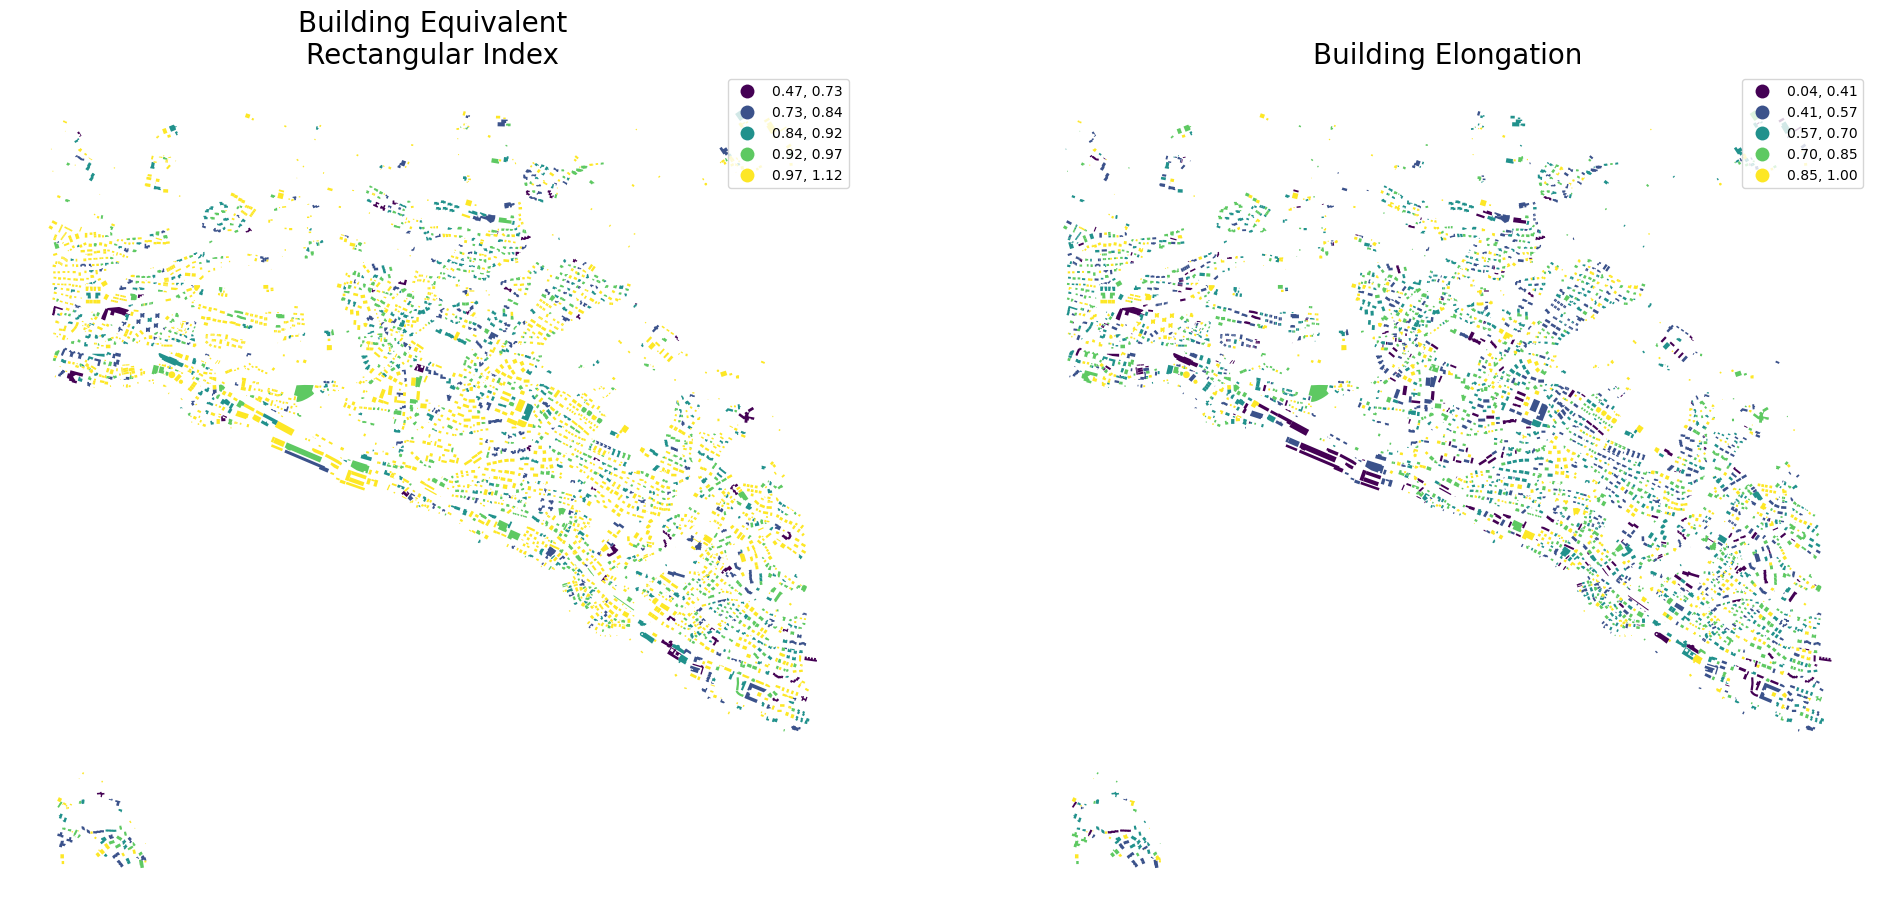

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Building Equivalent\nRectangular Index', fontsize=20)
ax[1].set_title('Building Elongation', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Uetikon/eri_and_elongation.svg')  

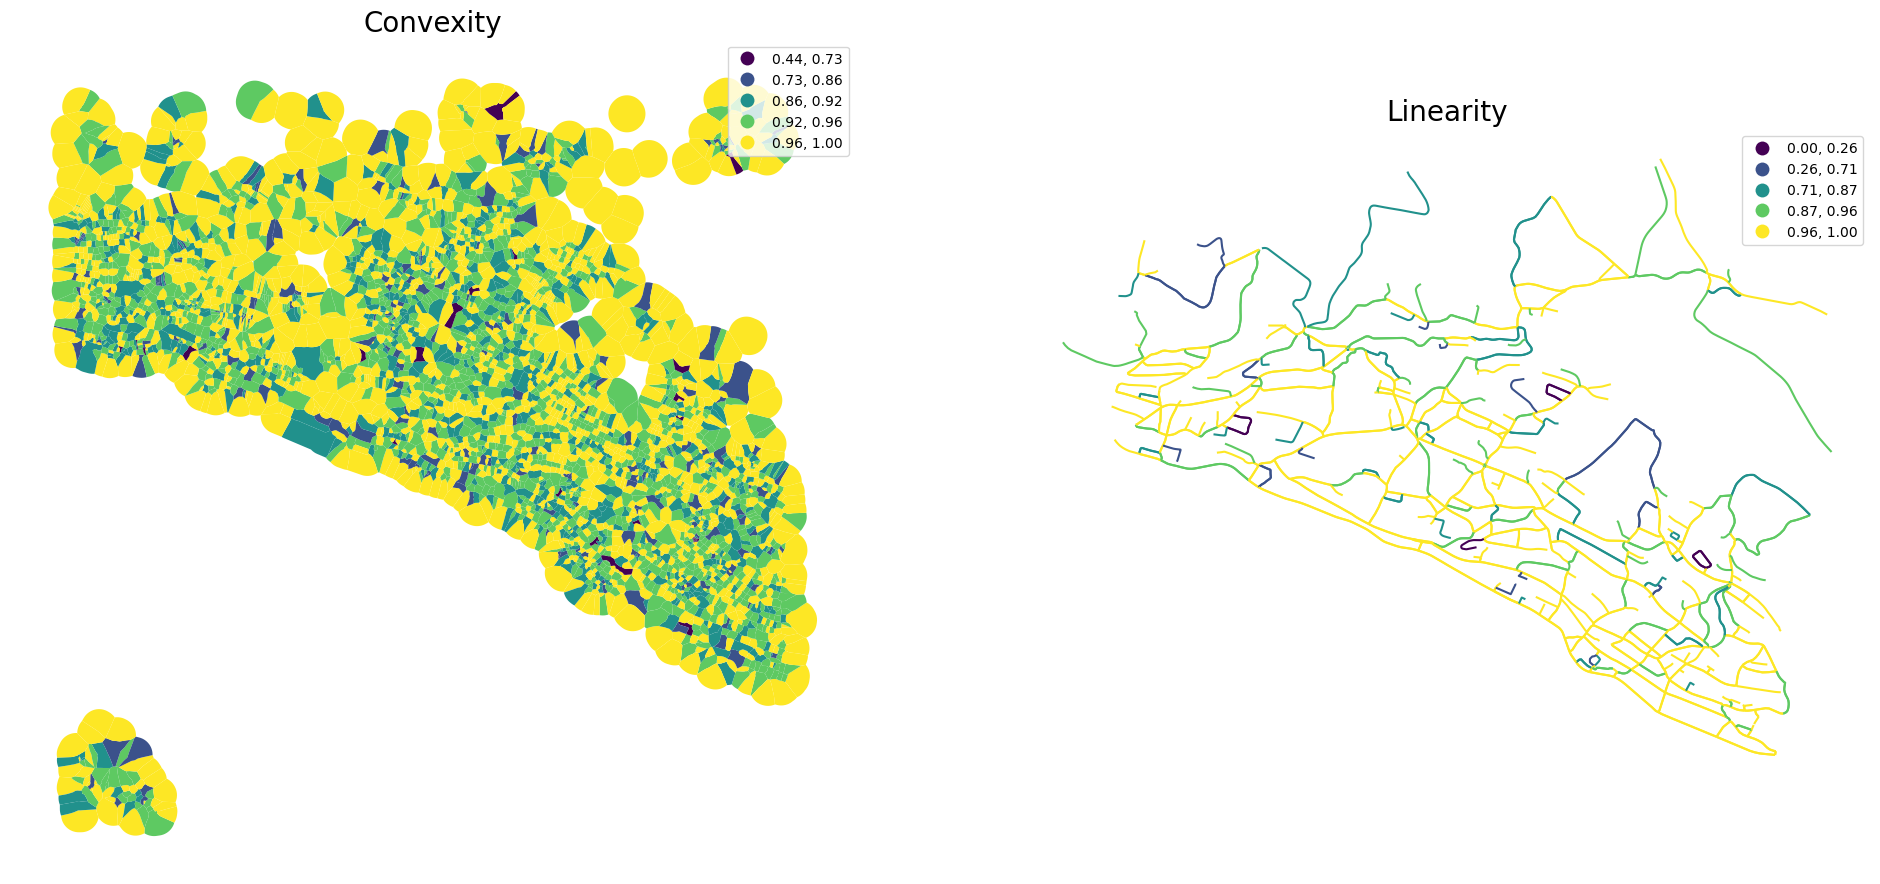

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Linearity', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Uetikon/convexity_and_linearity.svg')  

### Spatial distribution

In [29]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series

/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/momepy/distribution.py:214: FutureWarning: Class based API like `momepy.SharedWalls` or `momepy.SharedWallsRatio` is deprecated. Replace it with `momepy.shared_walls` or explicitly computing `momepy.shared_walls / gdf.length` respectively to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  super().__init__(gdf)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


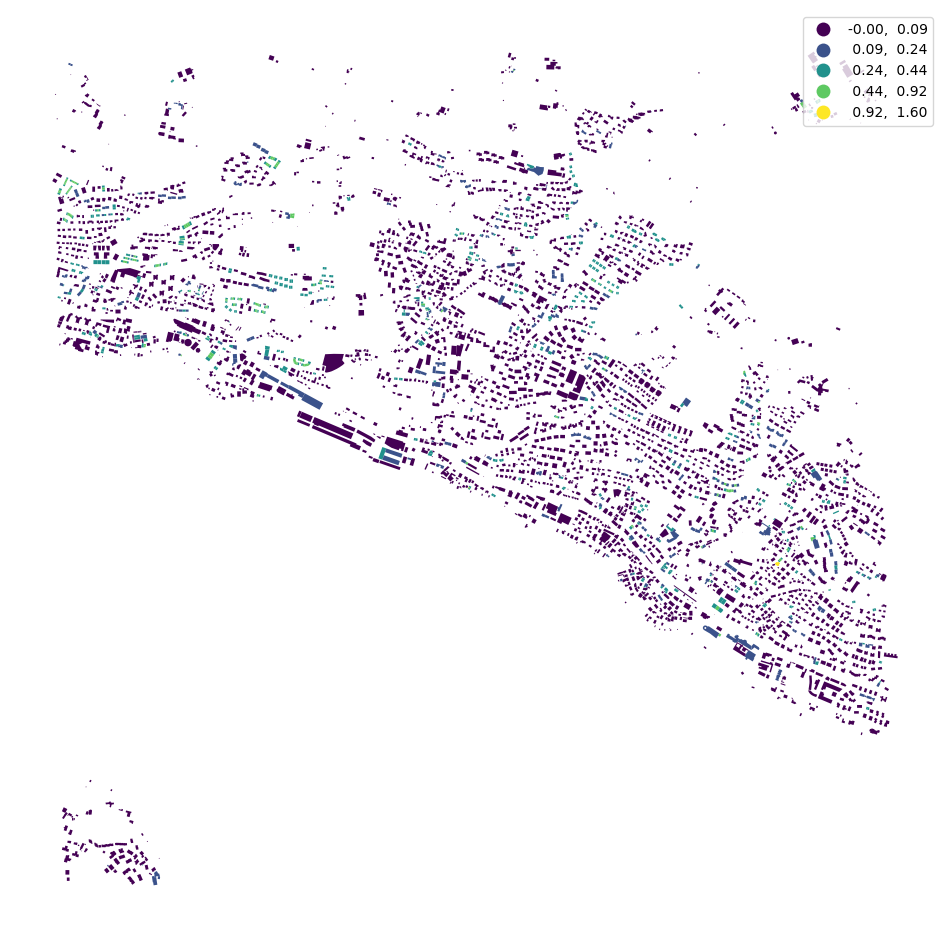

In [30]:
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

plt.savefig('../results/Uetikon/sharedwalls.svg')  

Generate spatial weights matrix using `libpysal`.

In [31]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

In [32]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/1669107924.py:1: FutureWarning: Class based API like `momepy.Neighbors` is deprecated. Replace it with `momepy.neighbors` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/1669107924.py:2: FutureWarning: `momepy.CoveredArea` is deprecated. Replace it with `.describe()` method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series


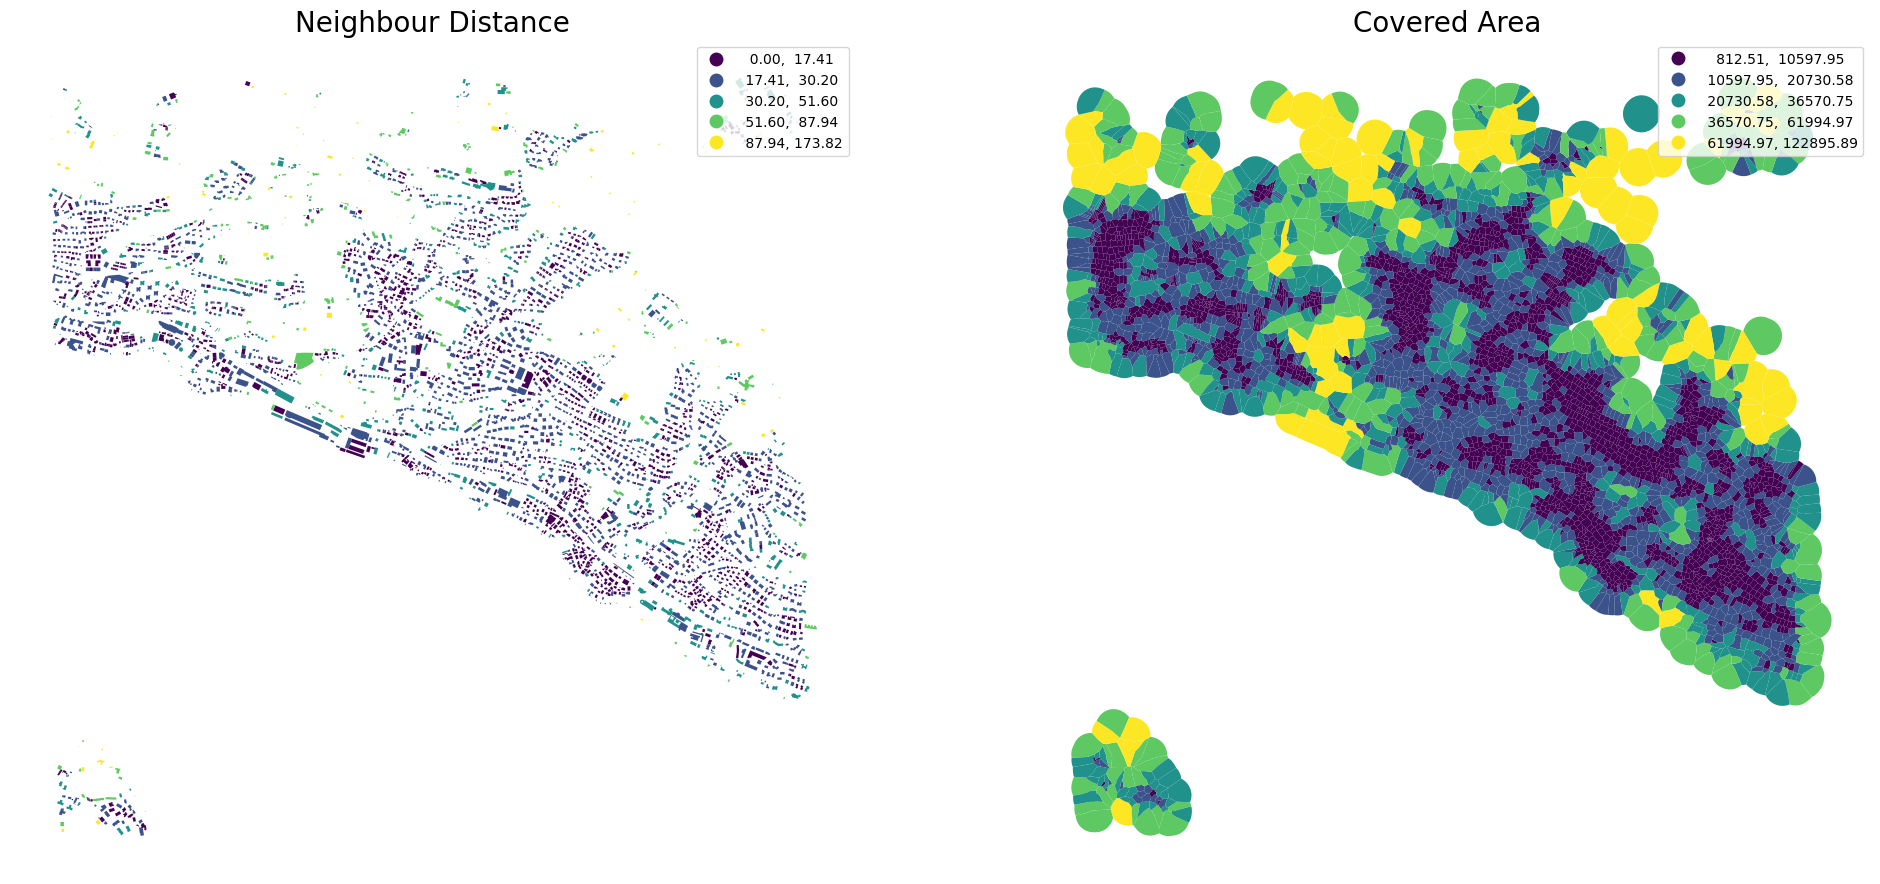

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Neighbour Distance', fontsize=20)
ax[1].set_title('Covered Area', fontsize=20)


ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Uetikon/neighbourdist_and_coveredarea.svg')  

In [34]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', queen_3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/3221532125.py:1: FutureWarning: `momepy.sw_high` is deprecated. Replace it with .higher_order() method of libpysal.graph.Graph or pin momepy version <1.0. This class will be removed in 1.0. 
  queen_3 = momepy.sw_high(k=3, weights=queen_1)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/3221532125.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/3221532125.py:4: FutureWarning: Class based API like `momepy.MeanInterbuildingDistance` is deprecated. Replace it with `momepy.mean_interbuilding_distance` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings['interbuilding_distance'] 

In [35]:
#fig, ax = plt.subplots(1, 2, figsize=(24, 12))
#
#buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
#buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)
#
#ax[0].set_axis_off()
#ax[1].set_axis_off()

In [36]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/2648127835.py:1: FutureWarning: Class based API like `momepy.StreetProfile` is deprecated. Replace it with `momepy.street_profile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  profile = momepy.StreetProfile(streets, buildings)
/Users/mtwente/anaconda3/envs/maxvogt/lib/python3.11/site-packages/pandas/core/arraylike.py:492: RuntimeWarning: invalid value encountered in intersection
  return getattr(ufunc, method)(*new_inputs, **kwargs)


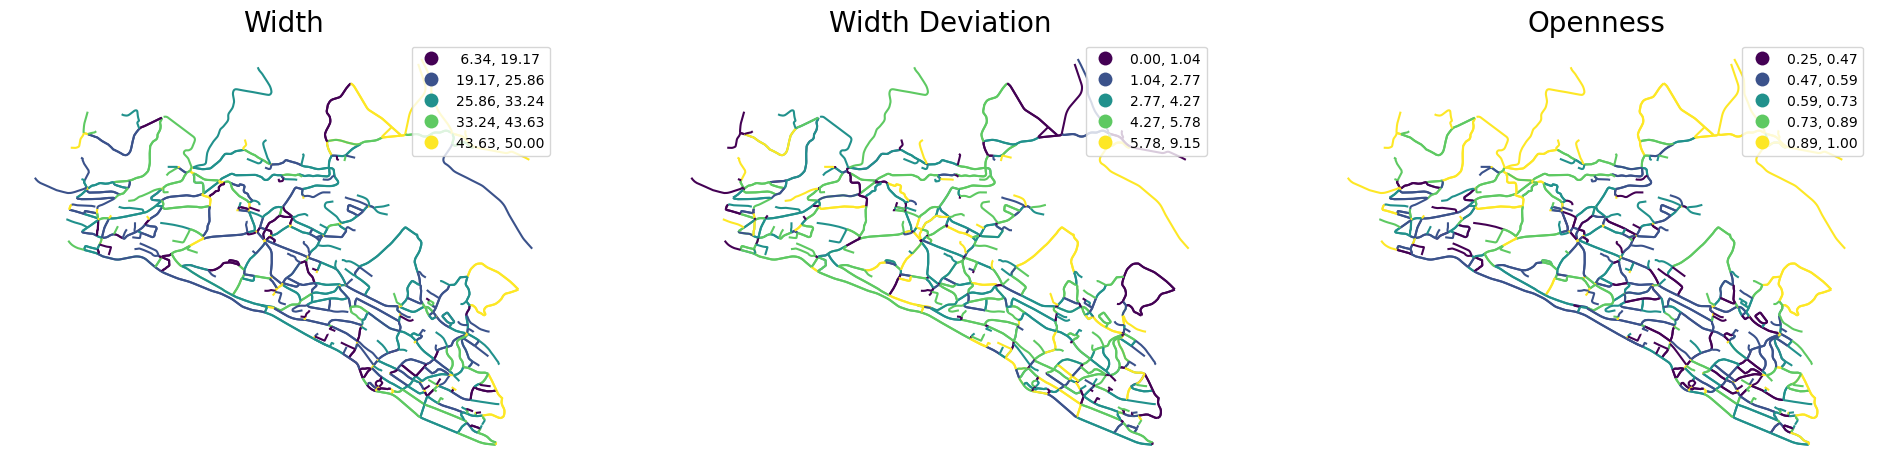

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_title('Width', fontsize=20)
ax[1].set_title('Width Deviation', fontsize=20)
ax[2].set_title('Openness', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Uetikon/road_network.svg')  

### Intensity

In [38]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/1819725789.py:1: FutureWarning: `momepy.AreaRatio` is deprecated. Replace it with a direct division of areas or momepy.describe_agg() or pin momepy version <1.0. This class will be removed in 1.0. 
  tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series


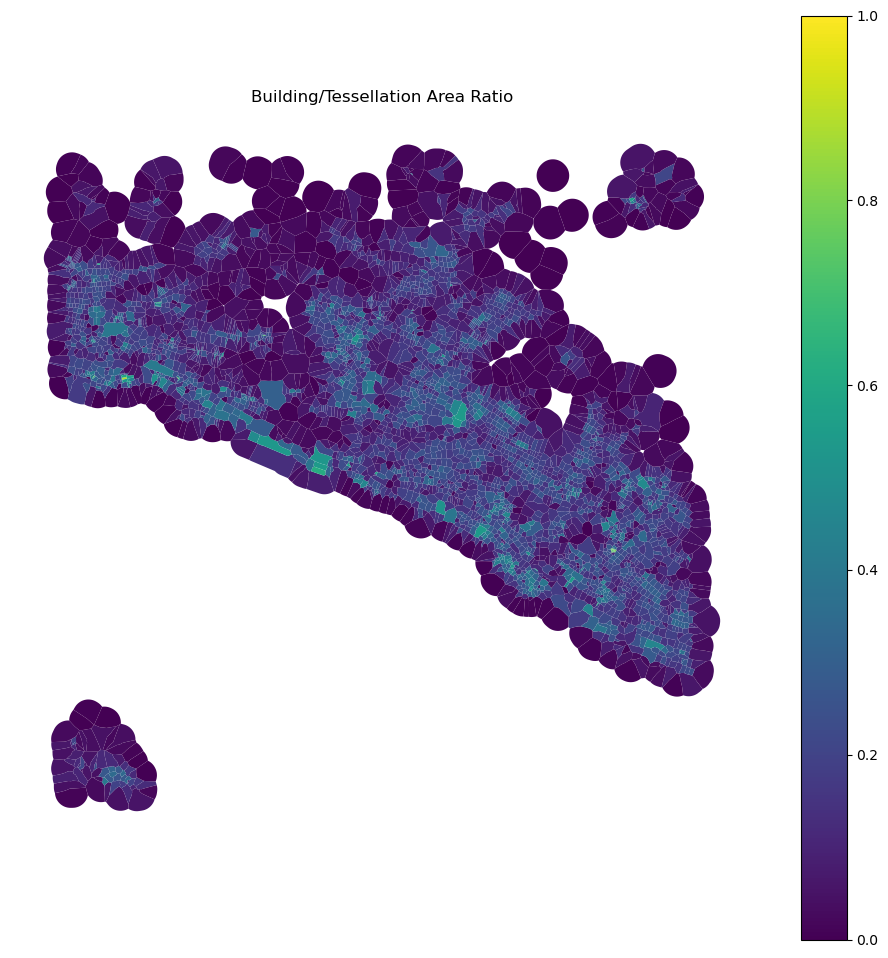

In [39]:
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()
plt.title("Building/Tessellation Area Ratio")

plt.savefig('../results/Uetikon/tessellation_ratio.svg')  

### Connectivity

In [40]:
graph = momepy.gdf_to_nx(streets)

In [41]:
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")

  0%|          | 0/460 [00:00<?, ?it/s]

  0%|          | 0/460 [00:00<?, ?it/s]

In [42]:
nodes, streets = momepy.nx_to_gdf(graph)

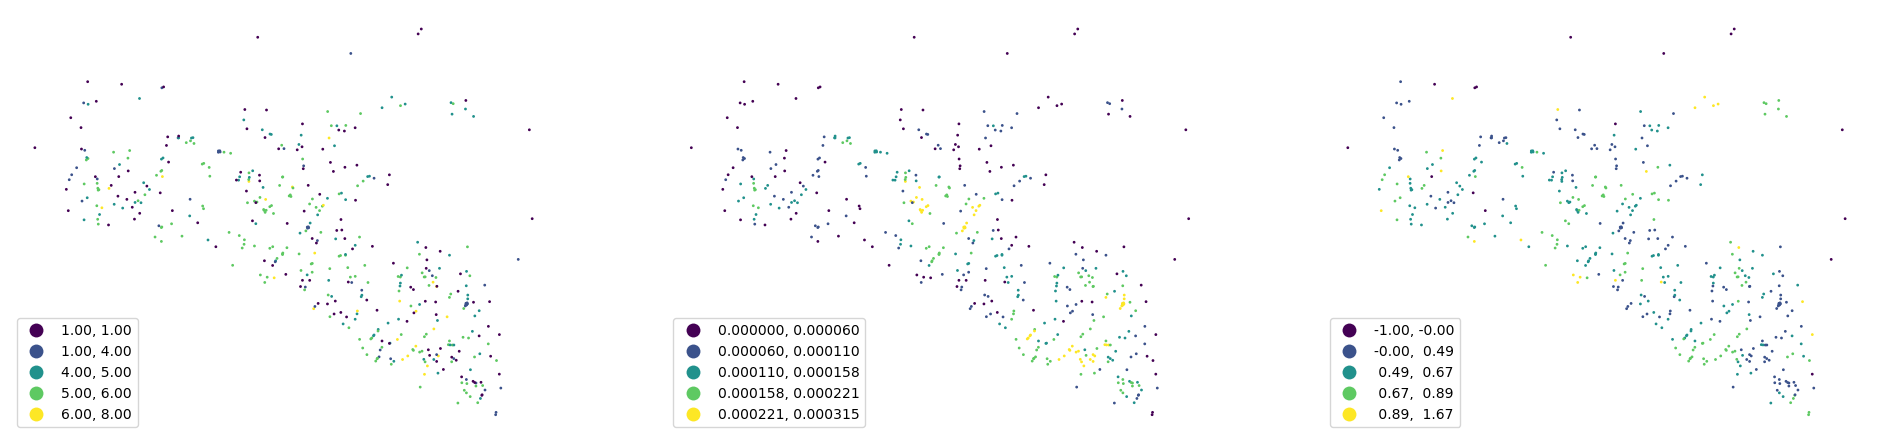

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig('../results/Uetikon/connectivity.svg')  

In [44]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/403706460.py:1: FutureWarning: Class based API like `momepy.get_node_id` is deprecated. Replace it with `momepy.get_nearest_node` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")


  0%|          | 0/4208 [00:00<?, ?it/s]

Link all data together (to tessellation cells or buildings).

In [45]:
tessellation

uID                                           geometry    nID  \
0      114  POLYGON ((2695834.746 1233625.421, 2695834.355...  290.0   
1     3871  POLYGON ((2695912.926 1233680.031, 2695912.103...  290.0   
2      113  POLYGON ((2695716.487 1233622.470, 2695714.872...  290.0   
3       85  POLYGON ((2695885.722 1233697.108, 2695884.820...  290.0   
4       86  POLYGON ((2695859.675 1233704.471, 2695859.293...  290.0   
...    ...                                                ...    ...   
4203  1730  POLYGON ((2693502.193 1236665.263, 2693501.147...  882.0   
4204  1737  POLYGON ((2693217.394 1236885.063, 2693214.830...  887.0   
4205  2834  POLYGON ((2693015.371 1236882.403, 2693020.965...  887.0   
4206  1736  POLYGON ((2693305.911 1236902.127, 2693304.809...  887.0   
4207  3040  POLYGON ((2692964.604 1236996.397, 2692962.494...  872.0   

              area  convexity  neighbors  covered_area       car  
0     14529.059499   0.960915   0.012374  49413.369297  0.061070  
1     16154.907417   0.991230   0.008214  44341.801643  0.030395  
2      6049.056428   0.938012   0.013623  31319.031254  0.083529  
3      1151.457783   0.959460   0.028674  36242.691622  0.235791  
4      1210.009533   0.929897   0.034027  23280.238790  0.222167  
...            ...        ...        ...           ...       ...  
4203  30279.560171   0.999617   0.006327  79420.950415  0.002960  
4204  10909.899358   0.875260   0.006216  77137.743463  0.016618  
4205  31272.406032   0.998710   0.006240  95116.350768  0.003120  
4206  17301.667012   0.995261   0.003879  45865.337431  0.004820  
4207  27157.256090   0.925868   0.001520  44505.341063  0.019216  

[4208 rows x 8 columns]

In [46]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [47]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'x', 'y', 'degree', 'closeness',
       'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [48]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API will be removed in 1.0. 
  perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
/var/folders/vs/1r1r5k5x12v5dj0w9z79tj3c0000gn/T/ipykernel_47370/962013058.py:3: FutureWarning: Class based API like `momepy.Percentiles` is deprecated. Replace it with `momepy.percentile` to use functional API instead or pin momepy version <1.0. Class-based API

In [49]:
percentiles_joined = pandas.concat(percentiles, axis=1)

In [50]:
percentiles_joined

area_x_25     area_x_50     area_x_75  convexity_25  convexity_50  \
0      1234.195711   1697.119772   6572.921216      0.927708      0.948499   
1      1180.733658   1596.227293   5129.051764      0.931741      0.952624   
2      1377.199665   1596.548889   2412.642588      0.933585      0.951027   
3      1180.733658   1697.119772   7628.306210      0.935449      0.952624   
4      1180.733658   1596.227293   4623.156909      0.931741      0.948499   
...            ...           ...           ...           ...           ...   
4203   3552.112057   6538.909867  12081.342732      0.924914      0.979721   
4204  13138.089645  17500.928017  23062.392331      0.969921      0.994111   
4205  10658.242967  17301.667012  18449.858958      0.956905      0.992204   
4206  13138.089645  17348.084973  18449.858958      0.989153      0.995261   
4207  17500.928017  17792.980202  22544.722717      0.957433      0.990979   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0         0.963880      0.015597      0.033700      0.041871     13172.287270   
1         0.968881      0.018242      0.033700      0.040639     13172.287270   
2         0.963410      0.024026      0.034614      0.042003     12888.927072   
3         0.963880      0.015597      0.031154      0.040639     13588.515771   
4         0.960188      0.018242      0.033700      0.042307     13172.287270   
...            ...           ...           ...           ...              ...   
4203      0.992960      0.010532      0.016468      0.020503     32398.112727   
4204      0.997345      0.005048      0.007052      0.010812     74864.937485   
4205      0.996751      0.006228      0.009274      0.012447     45374.852644   
4206      0.997345      0.006228      0.007776      0.010812     76457.745279   
4207      0.994926      0.004983      0.006228      0.007008     76457.745279   

      ...          y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ...  1.233838e+06        4.5        6.0        6.0      0.000075   
1     ...  1.233838e+06        4.0        5.0        6.0      0.000075   
2     ...  1.233796e+06        6.0        6.0        6.0      0.000075   
3     ...  1.233817e+06        4.0        6.0        6.0      0.000062   
4     ...  1.233838e+06        4.5        6.0        6.0      0.000075   
...   ...           ...        ...        ...        ...           ...   
4203  ...  1.236643e+06        1.0        5.0        5.0      0.000036   
4204  ...  1.236695e+06        3.0        5.0        5.0      0.000030   
4205  ...  1.236643e+06        5.0        5.0        5.0      0.000041   
4206  ...  1.236643e+06        5.0        5.0        5.0      0.000041   
4207  ...  1.236720e+06        3.0        5.0        5.0      0.000068   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0         0.000107      0.000115       0.666667       0.736842       0.736842  
1         0.000109      0.000115       0.666667       0.736842       0.736842  
2         0.000075      0.000115       0.666667       0.666667       0.736842  
3         0.000107      0.000115       0.666667       0.736842       0.757310  
4         0.000109      0.000115       0.666667       0.736842       0.736842  
...            ...           ...            ...            ...            ...  
4203      0.000072      0.000137       0.400000       0.428571       0.448276  
4204      0.000137      0.000137       0.428571       0.448276       0.448276  
4205      0.000137      0.000137       0.438424       0.448276       0.448276  
4206      0.000137      0.000137       0.438424       0.448276       0.448276  
4207      0.000137      0.000137       0.224138       0.448276       0.448276  

[4208 rows x 66 columns]

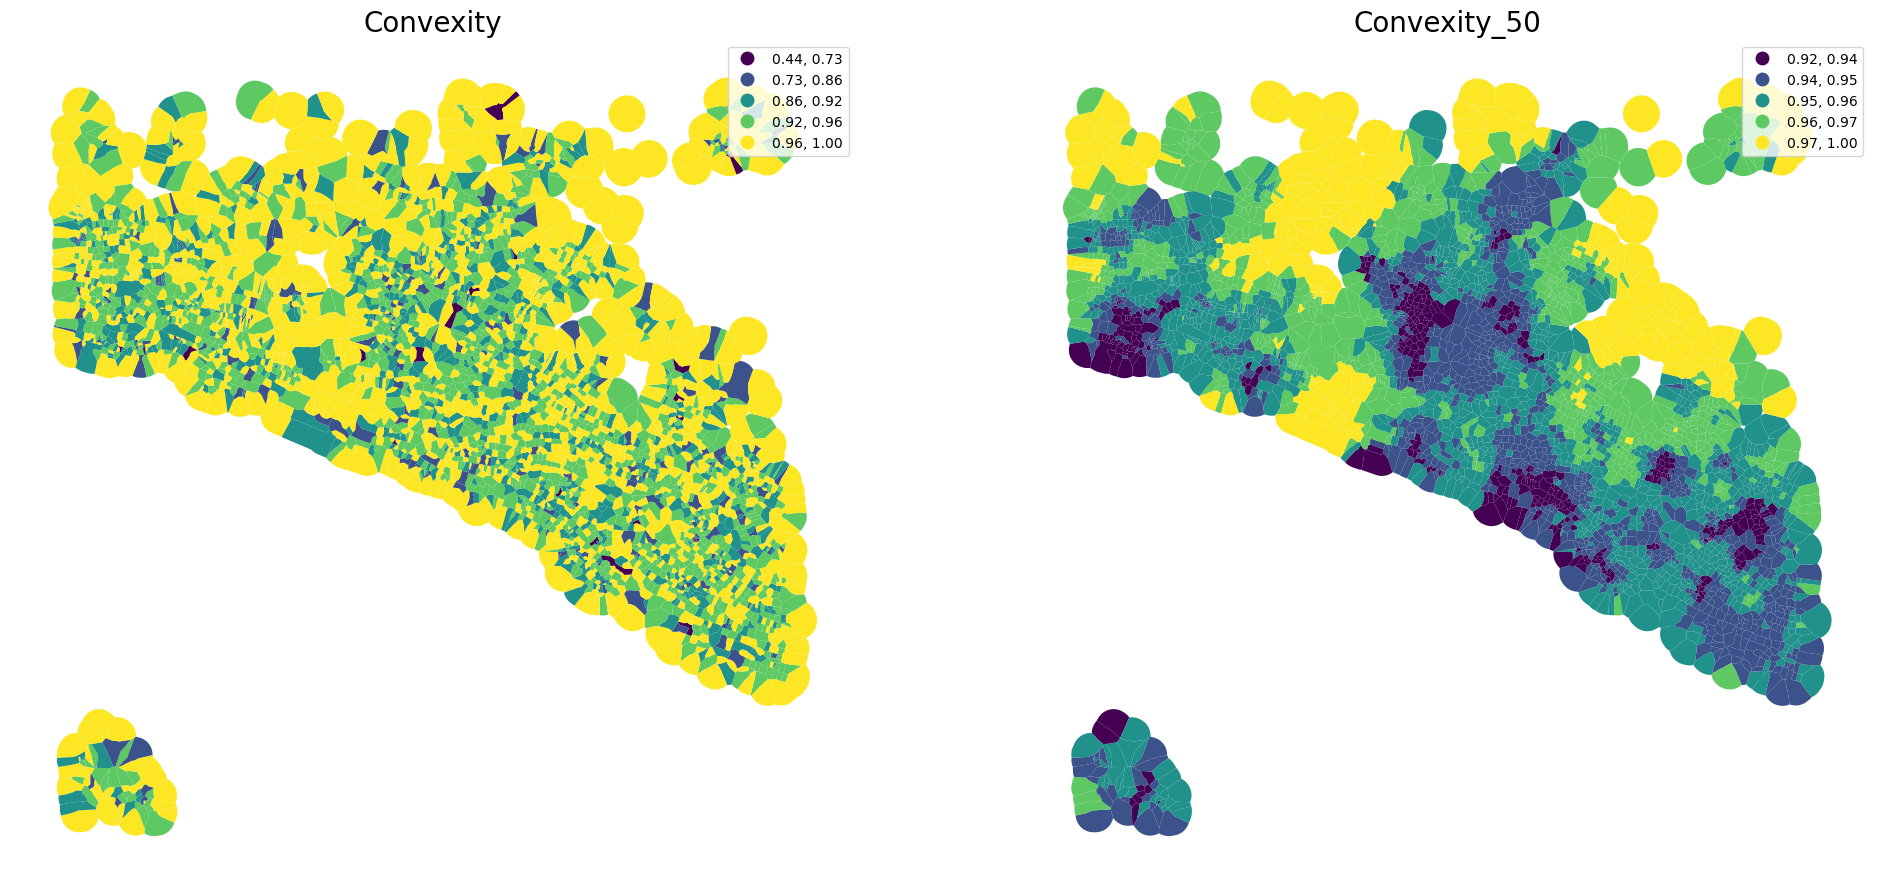

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_title('Convexity', fontsize=20)
ax[1].set_title('Convexity_50', fontsize=20)

ax[0].set_axis_off()
ax[1].set_axis_off()

plt.savefig('../results/Uetikon/convexity.svg')  

## Clustering

Standardize values before clustering.

In [53]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()

In [54]:
standardized

area_x_25  area_x_50  area_x_75  convexity_25  convexity_50  \
0      0.362944   0.089853   1.423248      0.164120     -0.627222   
1      0.302180   0.015336   0.862344      0.450249     -0.207035   
2      0.525481   0.015573  -0.192907      0.581107     -0.369697   
3      0.302180   0.089853   1.833236      0.713364     -0.207035   
4      0.302180   0.015336   0.665817      0.450249     -0.627222   
...         ...        ...        ...           ...           ...   
4203   2.997463   3.665896   3.563120     -0.034126      2.553274   
4204  13.892782  11.762210   7.828958      3.159418      4.019154   
4205  11.074215  11.615040   6.037115      2.235847      3.824983   
4206  13.892782  11.649323   6.037115      4.524077      4.136345   
4207  18.851538  11.977913   7.627858      2.273285      3.700134   

      convexity_75  neighbors_25  neighbors_50  neighbors_75  covered_area_25  \
0        -1.391476     -1.721919     -0.668029     -0.724829         0.637868   
1        -0.699938     -1.435731     -0.668029     -0.844019         0.637868   
2        -1.456348     -0.809867     -0.572934     -0.712131         0.591785   
3        -1.391476     -1.721919     -0.932563     -0.844019         0.705560   
4        -1.901949     -1.435731     -0.668029     -0.682725         0.637868   
...            ...           ...           ...           ...              ...   
4203      2.629306     -2.269881     -2.459062     -2.791308         3.764595   
4204      3.235623     -2.863324     -3.437832     -3.728438        10.671043   
4205      3.153393     -2.735624     -3.206781     -3.570320         5.875023   
4206      3.235623     -2.735624     -3.362513     -3.728438        10.930084   
4207      2.901182     -2.870351     -3.523436     -4.096357        10.930084   

      ...      y_75  degree_25  degree_50  degree_75  closeness_25  \
0     ... -2.239376   0.207254   0.565778  -0.028334     -0.404747   
1     ... -2.239376  -0.062567  -0.304326  -0.028334     -0.404747   
2     ... -2.298533   1.016720   0.565778  -0.028334     -0.404747   
3     ... -2.268955  -0.062567   0.565778  -0.028334     -0.633441   
4     ... -2.239376   0.207254   0.565778  -0.028334     -0.404747   
...   ...       ...        ...        ...        ...           ...   
4203  ...  1.643464  -1.681499  -0.304326  -1.172765     -1.092845   
4204  ...  1.715927  -0.602211  -0.304326  -1.172765     -1.196603   
4205  ...  1.643464   0.477076  -0.304326  -1.172765     -1.010950   
4206  ...  1.643464   0.477076  -0.304326  -1.172765     -1.010950   
4207  ...  1.749679  -0.602211  -0.304326  -1.172765     -0.527176   

      closeness_50  closeness_75  meshedness_25  meshedness_50  meshedness_75  
0        -0.254115     -0.432977       0.830266       0.704569       0.287146  
1        -0.219437     -0.432977       0.830266       0.704569       0.287146  
2        -0.761446     -0.432977       0.830266       0.349721       0.287146  
3        -0.254115     -0.432977       0.830266       0.704569       0.381046  
4        -0.219437     -0.432977       0.830266       0.704569       0.287146  
...            ...           ...            ...            ...            ...  
4203     -0.810939     -0.094167      -0.703399      -0.854227      -1.036712  
4204      0.231723     -0.094167      -0.539077      -0.754590      -1.036712  
4205      0.231723     -0.094167      -0.482415      -0.754590      -1.036712  
4206      0.231723     -0.094167      -0.482415      -0.754590      -1.036712  
4207      0.231723     -0.094167      -1.714824      -0.754590      -1.036712  

[4208 rows x 66 columns]

### How many clusters?

In [55]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=0)
cgram.fit(standardized.fillna(0))

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.049 seconds.
K=3 fitted in 0.047 seconds.
K=4 fitted in 0.049 seconds.
K=5 fitted in 0.071 seconds.
K=6 fitted in 0.125 seconds.
K=7 fitted in 0.090 seconds.
K=8 fitted in 0.118 seconds.
K=9 fitted in 0.088 seconds.
K=10 fitted in 0.102 seconds.
K=11 fitted in 0.104 seconds.


Clustergram(k_range=range(1, 12), backend='sklearn', method='kmeans', kwargs={'n_init': 10, 'random_state': 0})

In [56]:
show(cgram.bokeh())

In [57]:
cgram.labels.head()

1   2   3   4   5   6   7   8   9   10  11
0   0   0   0   0   1   5   2   7   8   5   3
1   0   0   0   0   1   5   2   7   8   5   3
2   0   0   0   0   0   5   2   7   8   5   3
3   0   0   0   0   1   5   2   7   8   5   3
4   0   0   0   0   0   5   2   7   8   5   3

In [58]:
merged["cluster"] = cgram.labels[8].values

In [59]:
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")

In [60]:
urban_types.explore("cluster", categorical=True, prefer_canvas=True, tiles="CartoDB Positron", tooltip=False)

## Export

Save cluster output geodata to geojson file:

In [61]:
urban_types.to_file('../data/raw/Uetikon.geojson', driver='GeoJSON')

## Utilities

Once you run the cell below, it hides all cells below the currently active one (aka presentation mode).

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: none;
}
</style>

Run this cell to turn the presentation mode off.

In [ ]:
%%html
<style>
.jp-Cell.jp-mod-selected ~ .jp-Cell {
    display: block;
}
</style>